## Exemplo Avançado: Implementando a Retropropagação Manualmente com TensorFlow

Este notebook é a continuação do nosso exemplo anterior. Se no primeiro vimos como os frameworks de alto nível facilitam o treino, aqui vamos fazer o oposto: vamos "abrir a caixa-preta" da função `tape.gradient()` e implementar nós mesmos o algoritmo de retropropagação (_backpropagation_) que foi deduzido matematicamente no livro.

O objetivo é demonstrar que as equações para `∂E/∂W` e `∂E/∂b` não são apenas teoria. Elas são o algoritmo.

Para isso, vamos:
1.  Modificar nosso modelo para que ele nos dê as ativações e linearidades de cada camada.
2.  Criar um loop de treino que calcula manualmente os gradientes para cada camada, de trás para frente, usando as fórmulas do livro.
3.  Usar o otimizador do TensorFlow apenas para *aplicar* os gradientes que nós mesmos calculamos.

Esta é a conexão mais profunda e explícita que podemos fazer entre a matemática do aprendizado e sua implementação computacional.

In [ ]:
# Passo 1: Importar as bibliotecas necessárias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Passo 2: Carregar o dataset MNIST
(x_train, z_train), (x_test, z_test) = tf.keras.datasets.mnist.load_data()

# Passo 3: Pré-processamento dos Dados
# 3.1 - Normalização e Achatamento (Flattening)
x_train = (x_train.astype("float32") / 255.0).reshape(60000, 784)
x_test = (x_test.astype("float32") / 255.0).reshape(10000, 784)

# 3.2 - One-Hot Encoding das Respostas Desejadas (z)
z_train = tf.keras.utils.to_categorical(z_train, num_classes=10)
z_test = tf.keras.utils.to_categorical(z_test, num_classes=10)

# DEPOIS, garantimos que o tipo do array seja float32 usando .astype()
z_train = z_train.astype('float32')
z_test = z_test.astype('float32')

print("Dados prontos para o treino!")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dados prontos para o treino!


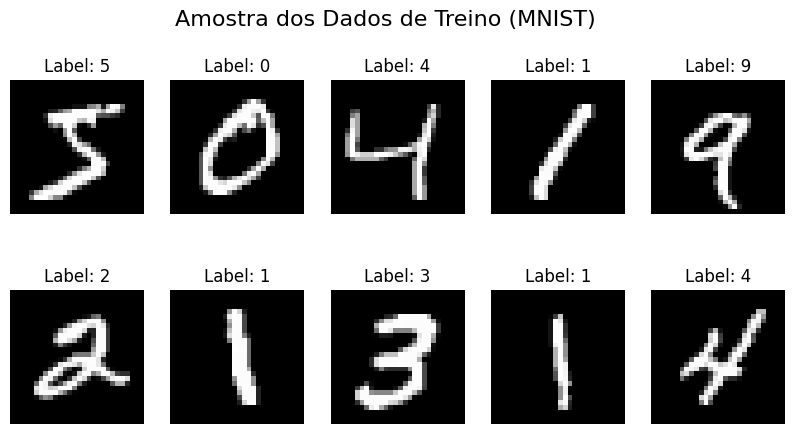

In [ ]:
# Vamos visualizar algumas imagens para entender com o que estamos trabalhando.
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(z_train[i])}")
    plt.axis('off')
plt.suptitle("Amostra dos Dados de Treino (MNIST)", fontsize=16)
plt.show()

In [ ]:
# # A classe do Perceptron foi modificada para retornar os valores intermediários
# # (linearidades 'y' e ativações 'a'), que são cruciais para a retropropagação.

# class Perceptron(tf.keras.Model):
#     def __init__(self, layer_sizes):
#         super(Perceptron, self).__init__()
#         self.num_camadas = len(layer_sizes)
#         self.camadas = []
#         for units in layer_sizes:
#             # Novamente, sem ativação aqui para podermos aplicá-la manualmente
#             self.camadas.append(tf.keras.layers.Dense(units, activation=None))

#     def call(self, x, return_internals=False):
#         """
#         Forward pass modificado. Se return_internals=True, ele retorna
#         a saída final e listas com as linearidades (y) e ativações (a) de cada camada.
#         """
#         a = x
#         ativacoes = [a] # Guarda a entrada como a primeira ativação (a^0)
#         linearidades = []

#         # Camadas ocultas
#         for camada in self.camadas[:-1]:
#             y = camada(a)
#             a = tf.nn.relu(y)
#             linearidades.append(y)
#             ativacoes.append(a)

#         # Última camada (saída)
#         y_final = self.camadas[-1](a)
#         P = tf.nn.softmax(y_final)
#         linearidades.append(y_final)
#         ativacoes.append(P)

#         if return_internals:
#             return P, linearidades, ativacoes

#         return P

In [ ]:
# # A classe do Perceptron foi modificada para usar Sigmoid na camada de saída.

# class Perceptron(tf.keras.Model):
#     def __init__(self, layer_sizes):
#         super(Perceptron, self).__init__()
#         self.num_camadas = len(layer_sizes)
#         self.camadas = []
#         for units in layer_sizes:
#             self.camadas.append(tf.keras.layers.Dense(units, activation=None))

#     def call(self, x, return_internals=False):
#         a = x
#         ativacoes = [a]
#         linearidades = []

#         # Camadas ocultas com ReLU
#         for camada in self.camadas[:-1]:
#             y = camada(a)
#             a = tf.nn.relu(y)
#             linearidades.append(y)
#             ativacoes.append(a)

#         # Última camada (saída)
#         y_final = self.camadas[-1](a)

#         # MUDANÇA: Aplicamos Sigmoid em vez de Softmax na última camada.
#         P = tf.nn.sigmoid(y_final)

#         linearidades.append(y_final)
#         ativacoes.append(P)

#         if return_internals:
#             return P, linearidades, ativacoes

#         return P

In [ ]:
# A classe do Perceptron foi modificada para retornar os valores intermediários
# (linearidades 'y' e ativações 'a'), que são cruciais para a retropropagação.

class Perceptron(tf.keras.Model):
    def __init__(self, layer_sizes):
        super(Perceptron, self).__init__()
        self.num_camadas = len(layer_sizes)
        self.camadas = []
        for units in layer_sizes:
            self.camadas.append(tf.keras.layers.Dense(units, activation=None))

    def call(self, x, return_internals=False):
        """
        Forward pass modificado. Se return_internals=True, ele retorna
        a saída final e listas com as linearidades (y) e ativações (a) de cada camada.
        """
        a = x

        # COMENTÁRIO ADICIONADO:
        # Iniciamos a lista de ativações com a própria entrada `x`.
        # Consideramos `x` como a 'ativação da camada 0' (a^0).
        # Isso simplifica o acesso à 'ativação anterior' (a^{l-1}) no loop de retropropagação.
        ativacoes = [a]
        linearidades = []

        # Camadas ocultas com ReLU
        for camada in self.camadas[:-1]:
            y = camada(a)
            a = tf.nn.relu(y)
            linearidades.append(y)
            ativacoes.append(a)

        # Última camada (saída)
        y_final = self.camadas[-1](a)
        P = tf.nn.sigmoid(y_final)
        linearidades.append(y_final)
        ativacoes.append(P)

        if return_internals:
            return P, linearidades, ativacoes

        return P

In [ ]:
# # --- Hiperparâmetros e Instâncias ---
# taxa_aprendizagem = 0.001
# epocas = 10
# tamanho_lote = 64

# modelo = Perceptron(layer_sizes=[128, 64, 10])
# otimizador = tf.keras.optimizers.Adam(learning_rate=taxa_aprendizagem)
# funcao_custo = tf.keras.losses.CategoricalCrossentropy()

# # --- Preparando os lotes de dados ---
# dataset_treino = tf.data.Dataset.from_tensor_slices((x_train, z_train))
# dataset_treino = dataset_treino.shuffle(buffer_size=60000).batch(tamanho_lote)

# # --- Loop de Treino ---
# historico_custo = []

# print("Iniciando o treino com retropropagação manual...")
# for epoca in range(epocas):
#     custo_medio_epoca = tf.keras.metrics.Mean()

#     for x_lote, z_lote in dataset_treino:

#         # 1. FORWARD PASS: obter saída e valores intermediários
#         P_lote, linearidades, ativacoes = modelo(x_lote, return_internals=True)

#         # 2. CÁLCULO DO ERRO
#         E = funcao_custo(z_lote, P_lote)

#         # ==========================================================
#         # 3. BACKPROPAGATION MANUAL (O Coração do Livro) - VERSÃO CORRIGIDA
#         # ==========================================================

#         # 3.1. Semente do Gradiente (para a última camada L)
#         # Para a combinação de custo Entropia Cruzada Categórica e ativação Softmax,
#         # a derivada do erro em relação à linearidade da última camada (dE/dy^L)
#         # simplifica para (P - z). É um resultado matemático muito conhecido e útil!
#         dE_dy = P_lote - z_lote # Delta inicial (dE/dy^L)

#         gradientes_finais = []

#         # 3.2. Loop Reverso pelas camadas
#         for l in reversed(range(modelo.num_camadas)):
#             camada = modelo.camadas[l]

#             # A ativação da camada anterior (a^{l-1}) é necessária.
#             # ativacoes[0] é a própria entrada x.
#             a_anterior = ativacoes[l]

#             # 3.3. Cálculo dos gradientes para a camada 'l' (dE/dW^l e dE/db^l)

#             # CORREÇÃO APLICADA AQUI: A ordem da multiplicação foi invertida
#             # para que a forma do gradiente seja [entradas, saídas], igual à de W.
#             # dE/dW^l = (a^{l-1})^T @ (dE/dy^l)
#             dE_dW = tf.matmul(a_anterior, dE_dy, transpose_a=True)

#             # dE/db^l é a soma do "delta" (dE/dy^l) ao longo dos exemplos do lote.
#             dE_db = tf.reduce_sum(dE_dy, axis=0)

#             # Adicionamos os gradientes calculados na lista, na ORDEM REVERSA da qual
#             # o TensorFlow espera (W, b), pois estamos inserindo no início da lista.
#             gradientes_finais.insert(0, dE_db)
#             gradientes_finais.insert(0, dE_dW)

#             # 3.4. Propagar o erro para a próxima iteração (para a camada l-1)
#             if l > 0:
#                 # dE/da^{l-1} = (dE/dy^l) @ W^l
#                 dE_da_anterior = tf.matmul(dE_dy, camada.kernel, transpose_b=True)

#                 # dE/dy^{l-1} = dE/da^{l-1} * a'(y^{l-1})
#                 derivada_relu = tf.cast(linearidades[l-1] > 0, dtype=tf.float32)
#                 dE_dy = dE_da_anterior * derivada_relu

#         # 4. ATUALIZAÇÃO DOS PESOS
#         # Aplicamos os gradientes que calculamos manualmente.
#         otimizador.apply_gradients(zip(gradientes_finais, modelo.trainable_variables))

#         custo_medio_epoca.update_state(E)

#     historico_custo.append(custo_medio_epoca.result())
#     print(f"Época {epoca + 1}/{epocas} - Custo Médio: {custo_medio_epoca.result():.4f}")

# print("Treino finalizado!")

In [ ]:
# # --- Hiperparâmetros e Instâncias ---
# taxa_aprendizagem = 0.001
# epocas = 10
# tamanho_lote = 64

# modelo = Perceptron(layer_sizes=[128, 64, 10])
# otimizador = tf.keras.optimizers.Adam(learning_rate=taxa_aprendizagem)

# # MUDANÇA: Usaremos Erro Quadrado Médio (MSE), que funciona bem com Sigmoid.
# # A derivada de E = (1/k)*sum(z-P)^2 é dE/dP = (2/k)*(P-z). Podemos usar simplesmente (P-z).
# funcao_custo = tf.keras.losses.MeanSquaredError()

# # --- Preparando os lotes de dados (inalterado) ---
# dataset_treino = tf.data.Dataset.from_tensor_slices((x_train, z_train))
# dataset_treino = dataset_treino.shuffle(buffer_size=60000).batch(tamanho_lote)

# # --- Loop de Treino ---
# historico_custo = []

# print("Iniciando o treino com retropropagação 100% explícita...")
# for epoca in range(epocas):
#     custo_medio_epoca = tf.keras.metrics.Mean()

#     for x_lote, z_lote in dataset_treino:

#         # 1. FORWARD PASS
#         P_lote, linearidades, ativacoes = modelo(x_lote, return_internals=True)

#         # 2. CÁLCULO DO ERRO
#         E = funcao_custo(z_lote, P_lote)

#         # ==========================================================
#         # 3. BACKPROPAGATION 100% MANUAL E EXPLÍCITA
#         # ==========================================================

#         # 3.1. Semente do Gradiente (para a última camada L) - SEM ATALHOS

#         # Passo 3.1.1: Calcular dE/da^L (ou dE/dP)
#         # Derivada do Erro Quadrado Médio: 2/N * (P - z). Ignoramos o fator de escala 2/N.
#         dE_daL = P_lote - z_lote

#         # Passo 3.1.2: Calcular da^L/dy^L
#         # Derivada da função Sigmoid: a * (1 - a)
#         aL = ativacoes[-1] # a^L é a última ativação, que é P_lote
#         daL_dyL = aL * (1 - aL)

#         # Passo 3.1.3: Aplicar a Regra da Cadeia para o delta inicial
#         # dE/dy^L = (dE/da^L) * (da^L/dy^L)
#         dE_dy = dE_daL * daL_dyL # Este é o nosso "delta" inicial.

#         gradientes_finais = []

#         # 3.2. Loop Reverso pelas camadas (lógica inalterada)
#         for l in reversed(range(modelo.num_camadas)):
#             camada = modelo.camadas[l]
#             a_anterior = ativacoes[l]

#             # 3.3. Cálculo dos gradientes para a camada 'l' (dE/dW^l e dE/db^l)
#             dE_dW = tf.matmul(a_anterior, dE_dy, transpose_a=True)
#             dE_db = tf.reduce_sum(dE_dy, axis=0)

#             gradientes_finais.insert(0, dE_db)
#             gradientes_finais.insert(0, dE_dW)

#             # 3.4. Propagar o erro para a próxima iteração (para a camada l-1)
#             if l > 0:
#                 dE_da_anterior = tf.matmul(dE_dy, camada.kernel, transpose_b=True)
#                 derivada_relu = tf.cast(linearidades[l-1] > 0, dtype=tf.float32)
#                 dE_dy = dE_da_anterior * derivada_relu

#         # 4. ATUALIZAÇÃO DOS PESOS
#         otimizador.apply_gradients(zip(gradientes_finais, modelo.trainable_variables))

#         custo_medio_epoca.update_state(E)

#     historico_custo.append(custo_medio_epoca.result())
#     print(f"Época {epoca + 1}/{epocas} - Custo Médio: {custo_medio_epoca.result():.4f}")

# print("Treino finalizado!")

In [ ]:
# --- Hiperparâmetros e Instâncias ---
taxa_aprendizagem = 0.001
epocas = 10
tamanho_lote = 64

modelo = Perceptron(layer_sizes=[128, 64, 10])
# otimizador = tf.keras.optimizers.Adam(learning_rate=taxa_aprendizagem)
# Descida Estocástica do Gradiente (em inglês: Stochastic Gradient Descent)
otimizador = tf.keras.optimizers.SGD(learning_rate=taxa_aprendizagem)
funcao_custo = tf.keras.losses.MeanSquaredError()

# --- Preparando os lotes de dados ---
dataset_treino = tf.data.Dataset.from_tensor_slices((x_train, z_train))
dataset_treino = dataset_treino.shuffle(buffer_size=60000).batch(tamanho_lote)

# --- Loop de Treino ---
historico_custo = []

print("Iniciando o treino com retropropagação 100% explícita...")
for epoca in range(epocas):
    custo_medio_epoca = tf.keras.metrics.Mean()

    for x_lote, z_lote in dataset_treino:

        P_lote, linearidades, ativacoes = modelo(x_lote, return_internals=True)
        E = funcao_custo(z_lote, P_lote)

        # ==========================================================
        # 3. BACKPROPAGATION 100% MANUAL E EXPLÍCITA
        # ==========================================================

        dE_daL = P_lote - z_lote
        aL = ativacoes[-1]
        daL_dyL = aL * (1 - aL)
        dE_dy = dE_daL * daL_dyL

        gradientes_finais = []

        for l in reversed(range(modelo.num_camadas)):
            camada = modelo.camadas[l]

            # COMENTÁRIO ADICIONADO:
            # A ativação da camada anterior (a^{l-1}) é necessária para o cálculo do gradiente.
            # Devido à forma como construímos a lista `ativacoes`, onde ativacoes[0] = a^0 (a entrada 'x'),
            # para a camada 'l' do modelo (que é 0-indexed), a ativação anterior a ela
            # está convenientemente armazenada em ativacoes[l].
            a_anterior = ativacoes[l]

            # COMENTÁRIO ADICIONADO:
            # Este é o passo mais crucial, onde a teoria se conecta com a implementação eficiente.
            # A equação do livro para dE/dW^l (para um exemplo) é um produto externo.
            # Para um LOTE, precisamos da SOMA dos produtos externos de cada exemplo.
            # A multiplicação de matrizes (a_anterior^T @ dE_dy) é a forma
            # matematicamente equivalente e computacionalmente otimizada de se fazer isso.
            # Análise das Formas: [entradas, lote] @ [lote, saídas] -> [entradas, saídas], que é a forma de W^l.
            dE_dW = tf.matmul(a_anterior, dE_dy, transpose_a=True)

            dE_db = tf.reduce_sum(dE_dy, axis=0)

            gradientes_finais.insert(0, dE_db)
            gradientes_finais.insert(0, dE_dW)

            if l > 0:
                dE_da_anterior = tf.matmul(dE_dy, camada.kernel, transpose_b=True)
                derivada_relu = tf.cast(linearidades[l-1] > 0, dtype=tf.float32)
                dE_dy = dE_da_anterior * derivada_relu

        otimizador.apply_gradients(zip(gradientes_finais, modelo.trainable_variables))
        custo_medio_epoca.update_state(E)

    historico_custo.append(custo_medio_epoca.result())
    print(f"Época {epoca + 1}/{epocas} - Custo Médio: {custo_medio_epoca.result():.4f}")

print("Treino finalizado!")

Iniciando o treino com retropropagação 100% explícita...
Época 1/10 - Custo Médio: 0.0443
Época 2/10 - Custo Médio: 0.0193
Época 3/10 - Custo Médio: 0.0156
Época 4/10 - Custo Médio: 0.0136
Época 5/10 - Custo Médio: 0.0122
Época 6/10 - Custo Médio: 0.0112
Época 7/10 - Custo Médio: 0.0103
Época 8/10 - Custo Médio: 0.0096
Época 9/10 - Custo Médio: 0.0090
Época 10/10 - Custo Médio: 0.0085
Treino finalizado!


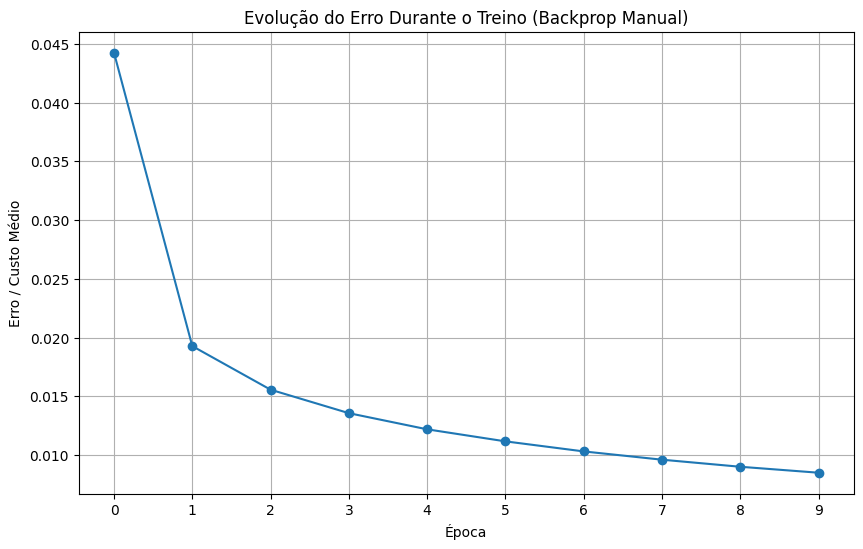

In [ ]:
# Plotar o gráfico da função de custo
plt.figure(figsize=(10, 6))
plt.plot(historico_custo, marker='o')
plt.xlabel("Época")
plt.ylabel("Erro / Custo Médio")
plt.title("Evolução do Erro Durante o Treino (Backprop Manual)")
plt.grid(True)
plt.xticks(range(epocas))
plt.show()

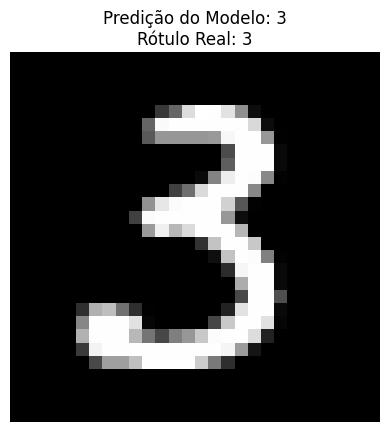

In [ ]:
def testar_modelo():
    idx_aleatorio = np.random.randint(0, len(x_test))
    img = x_test[idx_aleatorio]
    label_real = np.argmax(z_test[idx_aleatorio])

    img_para_previsao = np.expand_dims(img, axis=0)

    vetor_predicao = modelo(img_para_previsao)
    label_predito = np.argmax(vetor_predicao)

    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predição do Modelo: {label_predito}\nRótulo Real: {label_real}")
    plt.axis('off')
    plt.show()

# Execute esta célula várias vezes para testar!
testar_modelo()